# Fine-tuning SpeechT5 for multilingual TTS

This notebook demonstrates how to fine-tune the SpeechT5 model from 🤗 Transformers on the **text-to-speech** task. 

The unique thing about SpeechT5 is that the model is first pre-trained on a combination of speech-to-text and text-to-speech data, so that it learns a unified space of hidden representations shared by both text and speech. This allows us to fine-tune the same pretrained model on different tasks. Read more about SpeechT5 [in our blog post](https://huggingface.co/blog/speecht5).

In this notebook we will start from an existing fine-tuned TTS model that was originally trained on English speech from LibriTTS, and fine-tune it for the Dutch language using the VoxPopuli dataset.

This TTS model will support multiple speakers through x-vector speaker embeddings.

## Install required packages

We install Transformers from GitHub since not all the SpeechT5 features we need have been merged into an official release yet.


In [1]:
!pip install datasets soundfile speechbrain datasets[audio] SpeechBrain num2words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.0/519.0 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.

In [2]:
!pip install git+https://github.com/huggingface/transformers.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-f4qe2p9c
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-f4qe2p9c
  Resolved https://github.com/huggingface/transformers.git to commit 8f093fb799246f7dd9104ff44728da0c53a9f67a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.31.0.dev0-py3-none-any.whl size=7170473 sha256=d375a31fd235a81b115d28bd8470e5369fc1fa0c58f11db37148398d6d11773f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3noh_zu2/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea

In [3]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.9 MB/s eta 0:00:00


Do we have a GPU?

In [ ]:
!nvidia-smi

In case no GPU is found, from the menu choose **Runtime > Change runtime type** and set **Hardware accelerator** to **GPU**. Then restart the runtime to activate the GPU.

## Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again but for a new language. For more info about the original checkpoint, you can find its model card on the [Hugging Face Hub](https://huggingface.co/microsoft/speecht5_tts).

In [4]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [5]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")

In [ ]:
model.to(device)

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

## Load the dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/MyDrive/cs_172b_project

/content/drive/MyDrive/cs_172b_project


In [8]:
from datasets import load_dataset, Audio
dataset = load_dataset("audiofolder", data_dir="full_pierre_dataset771/")

Resolving data files:   0%|          | 0/772 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset audiofolder downloaded and prepared to /root/.cache/huggingface/datasets/audiofolder/default-c6692810239aca9a/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from datasets import load_dataset, Audio
dataset = load_dataset("audiofolder", data_dir="full_pierre_dataset/")

Resolving data files:   0%|          | 0/558 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset audiofolder downloaded and prepared to /root/.cache/huggingface/datasets/audiofolder/default-fbcc41d2958a7db5/0.0.0/6cbdd16f8688354c63b4e2a36e1585d05de285023ee6443ffd71c4182055c0fc. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [9]:
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [10]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 771
    })
})


Let's quickly check how many examples are in this dataset.

In [11]:
len(dataset['train'])

771

That should be sufficient for fine-tuning. We'll have a closer look at these examples soon.

## Clean up the text

The dataset may contain characters that are not in the SpeechT5 tokenizer vocabulary. Those will be converted to `<unk>` tokens. However, in Dutch a character such as `à` is used to stress syllables and so we can simply replace it with `a` without changing its meaning. The tokenizer supports some characters with diacritical marks, such as `é`, but not all of them.

Note that the VoxPopuli examples have both `raw_text` and `normalized_text`, which is all lowercase. The SpeechT5 tokenizer can handle uppercase just fine, however, it doesn't have any tokens for numbers. The `normalized_text` has the numbers written out as text, so we'll use that.



First we'll need to find out what the unsupported tokens are. The `SpeechT5Tokenizer` works with characters as tokens, so let's extract all distinct characters of the dataset. We write a mapping function `extract_all_chars` that concatenates the transcriptions from all examples into one long transcription and then transforms the string into a set of characters. It is important to pass the arguments `batched=True` and `batch_size=-1` to `dataset.map(...)` so that the mapping function has access to all transcriptions at once.

In [12]:
tokenizer = processor.tokenizer

In [13]:
import re
from num2words import num2words

def replace_matched_pattern(match):
    pattern = match.group()
    if re.match(r'[a-zA-Z]\d+', pattern):
        # if pattern is something like 'V1', 'X2', etc.
        number_part = re.search(r'\d+', pattern).group()  # get the number part
        letter_part = re.search(r'[a-zA-Z]', pattern).group()  # get the letter part
        return letter_part + " " + num2words(int(number_part))
    elif re.match(r'\d+[a-zA-Z]', pattern):
        # if pattern is something like '2n', '3m', etc.
        number_part = re.search(r'\d+', pattern).group()  # get the number part
        letter_part = re.search(r'[a-zA-Z]', pattern).group()  # get the letter part
        return num2words(int(number_part)) + " " + letter_part
    elif pattern.endswith('s') and len(pattern) == 3:
        # if pattern is a decade like '80s', '90s', etc.
        number_part = pattern[:-1]  # get the number part
        return num2words(int(number_part), to='year') + "s"
    elif pattern.endswith('s') and len(pattern) > 3:
        # if pattern is a century like '1800s', '1900s', etc.
        number_part = pattern[:-1]  # get the number part
        return num2words(int(number_part), to='year') + "s"
    else:
        # default case for standalone numbers
        return num2words(int(pattern))

def cleanup_text(inputs):
    text = inputs["transcription"]
    # adjust the regular expression to match 'V1', 'X2', etc., '2n', '3m', etc., and '80s', '90s', etc.
    text_with_numbers_replaced = re.sub(r'\b([a-zA-Z]\d+|\d+[a-zA-Z]|\d+s|\d+)\b', replace_matched_pattern, text)
    inputs["transcription"] = text_with_numbers_replaced
    return inputs

dataset = dataset.map(cleanup_text)


Map:   0%|          | 0/771 [00:00<?, ? examples/s]

In [14]:
def extract_all_chars(batch):
    all_text = " ".join(batch["transcription"])
    print(all_text)
    vocab = list(set(all_text))
    return {"vocab": vocab}

vocabs = dataset['train'].map(
    extract_all_chars, 
    batched=True, 
    batch_size=-1, 
    keep_in_memory=True,
    remove_columns=dataset['train'].column_names,
)

# Flattening the list of vocabs
flat_vocab_list = [item for sublist in vocabs["vocab"] for item in sublist]
dataset_vocab = set(flat_vocab_list)
tokenizer_vocab = {k for k,_ in tokenizer.get_vocab().items()}
print(dataset_vocab)


Map:   0%|          | 0/771 [00:00<?, ? examples/s]

 for instance, right? So there has to be a channel in a physical system, in the machine, there has to be a channel that conveys information about the targets all the way down to the  the targets all the way down to the deep weights. There is no other way, otherwise you cannot solve those critical equations and have the hidden weights depend on the target.  depends on the target. Okay? So there has to be this deep channel that conveys information about the targets and other things all the way from let's say the  other things, all the way from, let's say, the output back to the deep weights. In a physical system, in your digital simulation fantasy, you don't worry.  know simulation fantasy you don't worry about it but in a physical system you have to worry about it and so we can ask for instance where is the channel located what kind of information does it carry  what kind of information does it carry or what is the minimal amount of information that it has to carry and what is the rate 

Now we have two sets of characters, one with the vocabulary from the dataset and one with the vocabulary from the tokenizer. By taking the difference between these sets, we find the characters that are in the dataset but not in the tokenizer.

In [15]:
dataset_vocab - tokenizer_vocab

{' ', '%', '1', '2', 'è'}

Next, we will define a function to map these characters to valid tokens and then run it on the dataset. No need to handle space, that's already replaced by `▁` in the tokenizer.

And how many examples?

Just under 10k examples and ~40 unique speakers, which should be plenty.

Note: Even better would be to include the lengths of the examples. It's quite possible that speakers with few examples have plenty of audio available if these examples are relatively long. But it takes a while to scan through the entire dataset to find this information (since that requires loading and decoding each audio file), which is why we're skipping it here.

## Speakers

In [16]:
from collections import defaultdict
speaker_counts = defaultdict(int)

#initially speaker_id
for speaker in dataset["train"]["audio"]:
    speaker_counts[speaker] += 1

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x7fccd11924d0>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1246, in vio_read
    data_read = file.readinto(buf)
KeyboardInterrupt: 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:2778 in __getitem__            │
│                                                                                                  │
│   2775 │                                                                                         │
│   2776 │   def __getitem__(self, key):  # noqa: F811                                             │
│   2777 │   │   """Can be used to index columns (by string names) or rows (by integer index or i  │
│ ❱ 2778 │   │   return self._getitem(key)                                                         │
│   2779 │                                                                                         │
│   2780 │   def __getitems__(self, keys: List) -> List:                                           │
│   2781 │   │   """Can be used to get a batch using a list of integers indices."""                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:2763 in _getitem               │
│                                                                                                  │
│   2760 │   │   format_kwargs = format_kwargs if format_kwargs is not None else {}                │
│   2761 │   │   formatter = get_formatter(format_type, features=self._info.features, **format_kw  │
│   2762 │   │   pa_subtable = query_table(self._data, key, indices=self._indices if self._indice  │
│ ❱ 2763 │   │   formatted_output = format_table(                                                  │
│   2764 │   │   │   pa_subtable, key, formatter=formatter, format_columns=format_columns, output  │
│   2765 │   │   )                                                                                 │
│   2766 │   │   return formatted_output                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/formatting/formatting.py:624 in format_table    │
│                                                                                                  │
│   621 │   query_type = key_to_query_type(key)                                                    │
│   622 │   python_formatter = PythonFormatter(features=None)                                      │
│   623 │   if format_columns is None:                                                             │
│ ❱ 624 │   │   return formatter(pa_table, query_type=query_type)                                  │
│   625 │   elif query_type == "column":                                                           │
│   626 │   │   if key in format_columns:                                                          │
│   627 │   │   │   return formatter(pa_table, query_type)                                         │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/formatting/formatting.py:398 in __call__        │
│                                                                                                  │
│   395 │   │   if query_type == "row":                                                            │
│   396 │   │   │   return self.format_row(pa_table)                                               │
│   397 │   │   elif query_type == "column":                                                       │
│ ❱ 398 │   │   │   return self.format_column(pa_table)                                            │
│   399 │   │   elif query_type == "batch":                  

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

Around one-third of speakers has fewer than 100 examples. Approximately ten or so speakers have more than 500 examples. To speed up training, let's limit ourselves to speakers that have between 100 and 400 examples. This also makes the dataset more balanced.

In [ ]:
#nums. subject to change(100,400)
def select_speaker(speaker_id):
    return 100 <= speaker_counts[speaker_id] <= 400

dataset = dataset.filter(select_speaker, input_columns=["speaker_id"])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/dataset_dict.py:958 in filter                   │
│                                                                                                  │
│    955 │   │   if cache_file_names is None:                                                      │
│    956 │   │   │   cache_file_names = {k: None for k in self}                                    │
│    957 │   │   return DatasetDict(                                                               │
│ ❱  958 │   │   │   {                                                                             │
│    959 │   │   │   │   k: dataset.filter(                                                        │
│    960 │   │   │   │   │   function=function,                                                    │
│    961 │   │   │   │   │   with_indices=with_indices,                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/dataset_dict.py:959 in <dictcomp>               │
│                                                                                                  │
│    956 │   │   │   cache_file_names = {k: None for k in self}                                    │
│    957 │   │   return DatasetDict(                                                               │
│    958 │   │   │   {                                                                             │
│ ❱  959 │   │   │   │   k: dataset.filter(                                                        │
│    960 │   │   │   │   │   function=function,                                                    │
│    961 │   │   │   │   │   with_indices=with_indices,                                            │
│    962 │   │   │   │   │   input_columns=input_columns,                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:543 in wrapper                 │
│                                                                                                  │
│    540 │   │   │   "output_all_columns": self._output_all_columns,                               │
│    541 │   │   }                                                                                 │
│    542 │   │   # apply actual function                                                           │
│ ❱  543 │   │   out: Union["Dataset", "DatasetDict"] = func(self, *args, **kwargs)                │
│    544 │   │   datasets: List["Dataset"] = list(out.values()) if isinstance(out, dict) else [ou  │
│    545 │   │   # re-apply format to the output                                                   │
│    546 │   │   for dataset in datasets:                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/fingerprint.py:511 in wrapper                   │
│                                                                                                  │
│   508 │   │   │                                                                                  │
│   509 │   │   │   # Call actual function                                                         │
│   510 │   │   │                                                                                  │
│ ❱ 511 │   │   │   out = func(dataset, *args, **kwargs)                                           │
│   512 │   │   │                                            

In [ ]:
#how many speakers remain
len(set(dataset["speaker_id"]))

In [ ]:
#num of examples
len(dataset)

## Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we'll need to create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics. 

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [17]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name, 
    run_opts={"device": device}, 
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

Note: the `speechbrain/spkrec-xvect-voxceleb` model was trained on English speech from the VoxCeleb dataset, while our training examples are in Dutch. We're assuming here that this model will still make reasonable speaker embeddings, but this may not be true. First training an X-vector model on the target speech, such as Dutch, might work better.

## Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [ ]:
import numpy as np
# run for one speaker embedding for all clips
def prepare_dataset(example):
    # Load the audio data; if necessary, resample the audio to 16kHz
    audio = example["audio"]

    # Feature extraction and tokenization
    example = processor(
        text=example["transcription"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # Strip off the batch dimension
    example["labels"] = example["labels"][0]
    example["speaker_embeddings"] = np.zeros(shape = 512)
    
    return example

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["transcription"],
        audio_target=audio["array"], 
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

In [ ]:
dataset['train'][0]['transcription']

' for instance, right? So there has to be a channel, in a physical system, in the machine, there has to be a channel that conveys information about the targets all the way down to the'

Let's verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset['train'][0])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


This should give us:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer.decode(processed_example["input_ids"])

'for instance, right? So there has to be a channel in a physical system, in the machine, there has to be a channel that conveys information about the targets all the way down to the</s>'

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels should be a log-mel spectrogram with 80 mel bins.

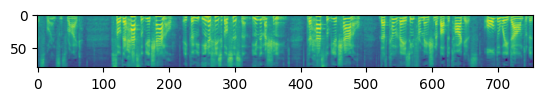

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

That all looks and sounds good! We can now process the entire dataset. This will take between 5 and 10 minutes.

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 771
    })
})

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# don't run
# run for one speaker embedding for all clips
audio_wav = [audio['array'] for audio in dataset['train']['audio']]

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_read at 0x7f81604aff40>:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/soundfile.py", line 1246, in vio_read
    data_read = file.readinto(buf)
KeyboardInterrupt: 


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 3>:3                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:2778 in __getitem__            │
│                                                                                                  │
│   2775 │                                                                                         │
│   2776 │   def __getitem__(self, key):  # noqa: F811                                             │
│   2777 │   │   """Can be used to index columns (by string names) or rows (by integer index or i  │
│ ❱ 2778 │   │   return self._getitem(key)                                                         │
│   2779 │                                                                                         │
│   2780 │   def __getitems__(self, keys: List) -> List:                                           │
│   2781 │   │   """Can be used to get a batch using a list of integers indices."""                │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:2763 in _getitem               │
│                                                                                                  │
│   2760 │   │   format_kwargs = format_kwargs if format_kwargs is not None else {}                │
│   2761 │   │   formatter = get_formatter(format_type, features=self._info.features, **format_kw  │
│   2762 │   │   pa_subtable = query_table(self._data, key, indices=self._indices if self._indice  │
│ ❱ 2763 │   │   formatted_output = format_table(                                                  │
│   2764 │   │   │   pa_subtable, key, formatter=formatter, format_columns=format_columns, output  │
│   2765 │   │   )                                                                                 │
│   2766 │   │   return formatted_output                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/formatting/formatting.py:624 in format_table    │
│                                                                                                  │
│   621 │   query_type = key_to_query_type(key)                                                    │
│   622 │   python_formatter = PythonFormatter(features=None)                                      │
│   623 │   if format_columns is None:                                                             │
│ ❱ 624 │   │   return formatter(pa_table, query_type=query_type)                                  │
│   625 │   elif query_type == "column":                                                           │
│   626 │   │   if key in format_columns:                                                          │
│   627 │   │   │   return formatter(pa_table, query_type)                                         │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/datasets/formatting/formatting.py:398 in __call__        │
│                                                                                                  │
│   395 │   │   if query_type == "row":                                                            │
│   396 │   │   │   return self.format_row(pa_table)                                               │
│   397 │   │   elif query_type == "column":                                                       │
│ ❱ 398 │   │   │   return self.format_column(pa_table)                                            │
│   399 │   │   elif query_type == "batch":                  

In [ ]:
# don't run
# run for one speaker embedding for all clips
import scipy.signal
import numpy as np

def resample_waveform(waveform, target_length):
    resampled_wav = []
    for wav in waveform:
      current_length = len(wav)
      resampled = scipy.signal.resample(wav, target_length)
      resampled_wav.append(resampled)

    return np.array(resampled_wav)

# Example usage
waveform = audio_wav
target_length = 192960 
resampled_waveform = resample_waveform(waveform, target_length)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# don't run
# run for one speaker embedding for all clips
speaker_embeddings = create_speaker_embedding(resampled_waveform)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [ ]:
# don't run
import datasets
# run for one speaker embedding for all clips
# Create a new dataset with speaker embeddings
new_dataset = datasets.Dataset.from_dict({
    'audio': dataset['train']['audio'],
    'transcription': dataset['train']['transcription'],
    'speaker_embeddings': 0
})

# Replace the original dataset with the new dataset
dataset['train'] = new_dataset

In [ ]:
dataset = dataset.map(prepare_dataset)

Map:   0%|          | 0/771 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (896 > 600). Running this sequence through the model will result in indexing errors


Some of the examples in the dataset are apparently longer than the maximum input length the model can handle (600 tokens), so we should remove those from the dataset. In fact, to allow for larger batch sizes we'll remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
     input_length = len(input_ids)
     return input_length < 200

dataset_test = dataset.filter(is_not_too_long, input_columns=["input_ids"])
dataset_test

Filter:   0%|          | 0/771 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription', 'input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 516
    })
})

How many examples are left?

## Train/test split

Create a basic train/test split. For our purposes, it's OK if the same speaker is part of both sets.

In [ ]:
final_dataset = dataset_test['train'].train_test_split(test_size=0.1)

What does the dataset look like now?

In [ ]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription', 'input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 464
    })
    test: Dataset({
        features: ['audio', 'transcription', 'input_ids', 'labels', 'speaker_embeddings'],
        num_rows: 52
    })
})

## Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )        

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 194]),
 'attention_mask': torch.Size([3, 194]),
 'labels': torch.Size([3, 870, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

## Training

It's always a good idea to upload model checkpoints directly to the [Hugging Face Hub](https://huggingface.co/) while training. To allow this, first log in to the Hub by entering your Hub authentication token:

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

The `use_cache=True` option is incompatible with gradient checkpointing. Disable it for training, otherwise it keeps complaining about it.

In [ ]:
model.config.use_cache = False

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./speecht5_tts_pierre",  # change to a repo name of your choice
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    learning_rate=1e-4,
    warmup_steps=20,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=50,
    eval_steps=50,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True
)

Create the trainer object using the model, dataset, and data collator.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=final_dataset["train"],
    eval_dataset=final_dataset["test"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

And with that, we're ready to start training!

Training will take several hours depending on your GPU or the one allocated to the Google Colab. Depending on your GPU, it is possible that you will encounter a CUDA "out-of-memory" error when you start training. In this case, you can reduce the `per_device_train_batch_size` incrementally by factors of 2 and increase `gradient_accumulation_steps` by 2x to compensate.

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
50,0.587200,0.536292
100,0.533500,0.475241
150,0.477700,0.454736
200,0.457300,0.442689
250,0.443400,0.446029
300,0.438900,0.438914
350,0.428000,0.438438
400,0.416800,0.438828
450,0.419800,0.434112
500,0.420600,0.432286


TrainOutput(global_step=500, training_loss=0.47923979568481445, metrics={'train_runtime': 997.0656, 'train_samples_per_second': 8.024, 'train_steps_per_second': 0.501, 'total_flos': 1307518691029848.0, 'train_loss': 0.47923979568481445, 'epoch': 19.61})

In [ ]:
# from numba import cuda

# device = cuda.get_current_device()
# device.reset()

If we do one more `push_to_hub()` after training we can get a nice model card built for us. We simply have to set the appropriate keyword arguments (kwargs). You can change these values to match your dataset, language and model name accordingly:

In [ ]:
kwargs = {
    "dataset_tags": "",
    "dataset": "baldi_lectures",  # a 'pretty' name for the training dataset
    "dataset_args": "config: nl, split: train",
    "language": "nl",
    "model_name": "speechT5_tts_baldi",  # a 'pretty' name for your model
    "finetuned_from": "microsoft/speecht5_tts",
    "tasks": "text-to-speech",
    "tags": "",
}

The training results can now be uploaded to the Hub. To do so, execute the `push_to_hub` command:

In [ ]:
#trainer.push_to_hub(**kwargs)

You can now share this model with anyone using the link on the Hub.

## Evaluate

After training finishes, let's use the model to synthesize some speech!

I'm loading the model from the Hugging Face Hub, as the Colab notebook was terminated before training finished (which is why it's a good idea to use `push_to_hub=True` when training).

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech
test_model = SpeechT5ForTextToSpeech.from_pretrained("./speecht5_tts_pierre/checkpoint-500")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = final_dataset["test"][0]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

torch.Size([1, 512])

Define some input text and tokenize it.

In [ ]:
text = "tractors for farming are used for plowing, cultivating the soil, and planting fields. Modern types of tractors can be used for a variety of tasks including shrubs, landscaping, moving or spreading fertilizer, and lawn maintenance."

In [ ]:
#tokenizer.decode(tokenizer(text)["input_ids"])

In [ ]:
inputs = processor(text=text, return_tensors="pt")

In [ ]:
inputs = inputs.to(device)  # move inputs to GPU
speaker_embeddings = speaker_embeddings.to(device)  # move speaker embeddings to GPU
model.to(device)

SpeechT5ForTextToSpeech(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5EncoderWithTextPrenet(
      (prenet): SpeechT5TextEncoderPrenet(
        (embed_tokens): Embedding(81, 768, padding_idx=1)
        (encode_positions): SpeechT5ScaledPositionalEncoding(
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (wrapped_encoder): SpeechT5Encoder(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (layers): ModuleList(
          (0-11): 12 x SpeechT5EncoderLayer(
            (attention): SpeechT5Attention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
     

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py:115 in decorate_context       │
│                                                                                                  │
│   112 │   @functools.wraps(func)                                                                 │
│   113 │   def decorate_context(*args, **kwargs):                                                 │
│   114 │   │   with ctx_factory():                                                                │
│ ❱ 115 │   │   │   return func(*args, **kwargs)                                                   │
│   116 │                                                                                          │
│   117 │   return decorate_context                                                                │
│   118                                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/speecht5/modeling_speecht5.py:2838   │
│ in generate_speech                                                                               │
│                                                                                                  │
│   2835 │   │   │     of shape `(config.decoder_layers, config.decoder_attention_heads, output_s  │
│   2836 │   │   │     input_sequence_length)` -- The outputs of the decoder's cross-attention la  │
│   2837 │   │   """                                                                               │
│ ❱ 2838 │   │   return _generate_speech(                                                          │
│   2839 │   │   │   self,                                                                         │
│   2840 │   │   │   input_ids,                                                                    │
│   2841 │   │   │   speaker_embeddings,                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/models/speecht5/modeling_speecht5.py:2579   │
│ in _generate_speech                                                                              │
│                                                                                                  │
│   2576 │   │   idx += 1                                                                          │
│   2577 │   │                                                                                     │
│   2578 │   │   # Run the decoder prenet on the entire output sequence.                           │
│ ❱ 2579 │   │   decoder_hidden_states = model.speecht5.decoder.prenet(output_sequence, speaker_e  │
│   2580 │   │                                                                                     │
│   2581 │   │   # Run the decoder layers on the last element of the prenet output.                │
│   2582 │   │   decoder_out = model.speecht5.decoder.wrapped_decoder(                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1501 in _call_impl            │
│                                                                                                  │
│   1498 │   │   if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks   │
│   1499 │   │   │   │   or _global_backward_pre_hooks or _global_backward_hooks                   │
│   1500 │   │   │   │   or _global_forward_hooks or _global_

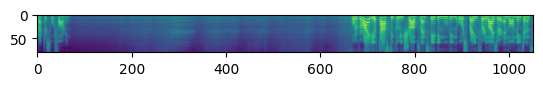

In [ ]:
# move tensor to cpu and convert to numpy
spectrogram_np = spectrogram.detach().cpu().numpy()

# plot spectrogram
plt.figure()
plt.imshow(spectrogram_np.T)
plt.show()


Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
# Move the spectrogram to the device where the vocoder model is
spectrogram = spectrogram.to(device)
vocoder.to(device)

# Now you can use this spectrogram as input to your vocoder model
with torch.no_grad():
    speech = vocoder(spectrogram)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>:2                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'spectrogram' is not defined

In [ ]:
from IPython.display import Audio
speech_cpu = speech.detach().cpu()
Audio(speech_cpu.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output3.wav", speech_cpu.numpy(), samplerate=16000)

## Building a demo

To showcase your newly fine-tuned model, make a demo on Hugging Face Spaces! We've created a [template Gradio demo](https://huggingface.co/spaces/Matthijs/speecht5-tts-demo) that you can easily copy and make your own.

Click the link to duplicate the template demo to your account: https://huggingface.co/spaces/Matthijs/speecht5-tts-demo?duplicate=true (or from the three-dot button at the top choose **Duplicate this Space**).

We recommend giving your space a similar name to your fine-tuned model (e.g. `speecht5_tts_voxpopuli_nl`) and setting the visibility to "Public".

Once you've duplicated the Space to your account, click **Files and versions > app.py > edit**. Change the model identifier to your fine-tuned model (line 9). Scroll to the bottom of the page and click **Commit changes to main**. The demo will reboot, this time using your fine-tuned model. 

You can share this demo with your friends and family so that they can use the model that you've trained!

## Conclusion

That's it, you've fine-tuned SpeechT5 for TTS on a custom dataset!

In our experience, it can be difficult to get good results out of this model. The results can be rather noisy and sometimes what the model outputs doesn't even sound like speech at all. A lot of this appears to be related to the speaker embeddings. Since SpeechT5 was pre-trained with English x-vectors, it gives the best results using those English speaker embeddings. So if the generated speech sounds bad, try using a different speaker embedding and it might improve.

Of course, the demo above was only trained for 3000 iterations. Training for longer should improve the results. Even so, the speech clearly is Dutch instead of English, and it does capture the voice characteristics of the speaker (compare to the original audio in the example).

Another thing to experiment with is the model's configuration. For example, try using `config.reduction_factor = 1` to see if this improves the results.

A final note on ethical concerns: While TTS technology has many beneficial uses, it can also be used for nefarious purposes such as imitating someone's voice without their permission. Please use TTS wisely and responsibly!